### This notebook generates the SD-CAPE relationships for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

In [15]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
pmax_array = nc_open_compile(file_years,"pmax")
tropical_rain_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) & (pmax_array >= np.percentile(pmax_array,75)) )[:,0]
#print(tropical_indx.shape)
print(tropical_rain_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_rain_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_rain_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_rain_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_rain_indx]
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERAI = negative_to_nan(pmax_array)[tropical_rain_indx]

-56.0
56.0
(124047,)


In [16]:
# creating cape array from different files and treating for negatives
cape_array = nc_open_compile(file_years,"cape")
cape_ERAI = negative_to_nan(cape_array)[tropical_rain_indx]
#capepre_array = nc_open_compile(file_years,"capepre")
#capepre_ERAI = negative_to_nan(capepre_array)[tropical_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERAI = negative_to_nan(capepre6_array)[tropical_rain_indx]
#capepre9_array = nc_open_compile(file_years,"capepre9")
#capepre9_ERAI = negative_to_nan(capepre9_array)[tropical_indx]

# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)[tropical_rain_indx]
qvpre_array = nc_open_compile( file_years, "qvpre", 'stack' )
qvpre_ERAI = negative_to_nan(qvpre_array)[tropical_rain_indx]
qvpre6_array = nc_open_compile( file_years, "qvpre6", 'stack' )
qvpre6_ERAI = negative_to_nan(qvpre6_array)[tropical_rain_indx]
qvpre9_array = nc_open_compile( file_years, "qvpre9", 'stack' )
qvpre9_ERAI = negative_to_nan(qvpre9_array)[tropical_rain_indx]

#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

In [17]:
# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )[tropical_rain_indx]
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )

# as in Singh et al. 2017 we calculate saturation deficit as the arithmetic mean
# between its values at 850, 700, and 550 hPa
i = np.argmin( np.abs(plev_ERAI - 85000) )
sd850_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000   # 1000 converts [kg kg-1] to [g kg-1]
sd850pre_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*1000
i = np.argmin( np.abs(plev_ERAI - 70000) )
sd700_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd700pre_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*100
i = np.argmin( np.abs(plev_ERAI - 55000) )
sd550_ERAI = (qvsat_ERAI[:,i] - qv_ERAI[:,i])*1000
sd550pre_ERAI = (qvsat_ERAI[:,i] - qvpre6_ERAI[:,i])*1000

sd_ERAI = (sd850_ERAI + sd700_ERAI + sd550_ERAI)/3
sdpre_ERAI = (sd850pre_ERAI + sd700pre_ERAI + sd550pre_ERAI)/3
print( 'Min, Mean, and Max SD [g kg-1]: ' + str(np.nanmin(sd_ERAI)) + ' ' + str(np.nanmedian(sd_ERAI)) + ' ' + str(np.nanmax(sd_ERAI)) )

Min, Mean, and Max SD [g kg-1]: -5.273211776938061 2.0172306404106637 9.586771613149454


### What does the probability distribution of saturation deficits look like?

[1.33333333 1.66666667 2.         2.33333333 2.66666667 3.
 3.33333333 3.66666667]
[10.71126267 11.5536853  11.13690778  9.78177626  8.08242037  6.22344756
  4.58455263  3.34066926]
65.41472183923936


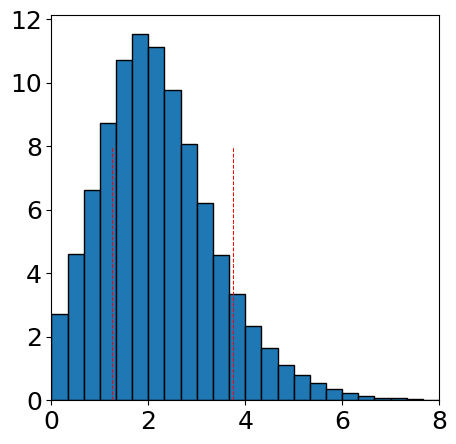

In [18]:
fig = plt.figure( figsize=(5,5) )
wgts = np.ones_like( sd_ERAI )/float(len(sd_ERAI))*100.
h, edges = np.histogram( sd_ERAI, bins=np.linspace(0,8,25), weights=wgts )
print(edges[4:12]) # 4:12 represent bins for SD = 1.25-3.75 g kg-1
print(h[4:12])
print(np.cumsum(h[4:12])[-1])
plt.hist( sd_ERAI, bins=np.linspace(0,8,25), weights=wgts, edgecolor='k' )
plt.plot( [1.25, 1.25], [0, 8], lw=0.75, ls='--', color='red' )
plt.plot( [3.75, 3.75], [0, 8], lw=0.75, ls='--', color='red' )
plt.xlim( [0,8] )
plt.show()

In [19]:
pc2 = 99
nbin = 30
sdupper = 5

# create bins for *positive* saturation deficits and evaluate corresponding CAPE percentiles
sd_bins, cape_vals, cape_95_vals, cape_99_vals, sd_error, cape_error, sd_max, cape_max = \
    bin_stat_function( nbin, 0, sdupper, sd_ERAI, cape_ERAI, pc2=pc2, threshold=100 )

In [20]:
# create bins in SD and evaluate corresponding CAPE percentiles for longest-lived systems
upp = np.percentile( lifetime_ERAI, 75 )
loo = np.percentile( lifetime_ERAI, 25 )
sd_bins_old, cape_vals_old, _, cape_99_vals_old, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERAI[lifetime_ERAI >= upp], cape_ERAI[lifetime_ERAI >= upp], pc2=pc2, threshold=100 )

# create bins in SD and evaluate corresponding CAPE percentiles for shortest-lived systems
sd_bins_young, cape_vals_young, _, cape_99_vals_young, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERAI[lifetime_ERAI <= loo], cape_ERAI[lifetime_ERAI <= loo], pc2=pc2, threshold=100 )

# create bins in SD and evaluate corresponding CAPE percentiles for smallest systems
upp = np.percentile( rad_ERAI, 75 )
loo = np.percentile( rad_ERAI, 25 )
sd_bins_small, cape_vals_small, _, cape_99_vals_small, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERAI[rad_ERAI <= loo], cape_ERAI[rad_ERAI <= loo], pc2=pc2, threshold=100 )

# create bins in SD and evaluate corresponding CAPE percentiles for largest systems
sd_bins_large, cape_vals_large, _, cape_99_vals_large, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERAI[rad_ERAI >= upp], cape_ERAI[rad_ERAI >= upp], pc2=pc2, threshold=100 )

# create bins in SD and evaluate corresponding CAPE percentiles for deepest systems
upp = np.percentile( minctt_ERAI, 75 )
loo = np.percentile( minctt_ERAI, 25 )
sd_bins_deep, cape_vals_deep, _, cape_99_vals_deep, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERAI[minctt_ERAI <= loo], cape_ERAI[minctt_ERAI <= loo], pc2=pc2, threshold=100 )

# create bins in SD and evaluate corresponding CAPE percentiles for shallowest systems
sd_bins_shallow, cape_vals_shallow, _, cape_99_vals_shallow, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERAI[minctt_ERAI >= upp], cape_ERAI[minctt_ERAI >= upp], pc2=pc2, threshold=100 )

In [21]:
sdpre_bins, cape_vals2, _, cape_99_vals2, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sdpre_ERAI, cape_ERAI, pc2=pc2, threshold=100 )

sd_bins2, capepre_vals, _, capepre_99_vals, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERAI, capepre6_ERAI, pc2=pc2, threshold=100 )

sdpre_bins2, capepre_vals2, _, capepre_99_vals2, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sdpre_ERAI, capepre6_ERAI, pc2=pc2, threshold=100 )

### Figure 6 - Binning of CAPE and saturation deficit across percentiles

(array([ 1.2164744 ,  2.83924641,  5.01745306,  7.70675631, 10.92489137,
       14.80890308, 19.17660242, 24.13278838, 29.55573291, 35.34063702,
       41.36416036, 47.33205962, 53.0919732 , 58.66727934, 63.64039437,
       68.3160415 , 72.48220433, 76.04456375, 79.22803454, 81.91814393,
       84.17535289, 86.14799229, 87.79091796, 89.17426459, 90.29883834,
       91.24767225, 92.05704289, 92.6890614 , 93.22353624]), array([0.        , 0.17241379, 0.34482759, 0.51724138, 0.68965517,
       0.86206897, 1.03448276, 1.20689655, 1.37931034, 1.55172414,
       1.72413793, 1.89655172, 2.06896552, 2.24137931, 2.4137931 ,
       2.5862069 , 2.75862069, 2.93103448, 3.10344828, 3.27586207,
       3.44827586, 3.62068966, 3.79310345, 3.96551724, 4.13793103,
       4.31034483, 4.48275862, 4.65517241, 4.82758621, 5.        ]), <BarContainer object of 29 artists>)


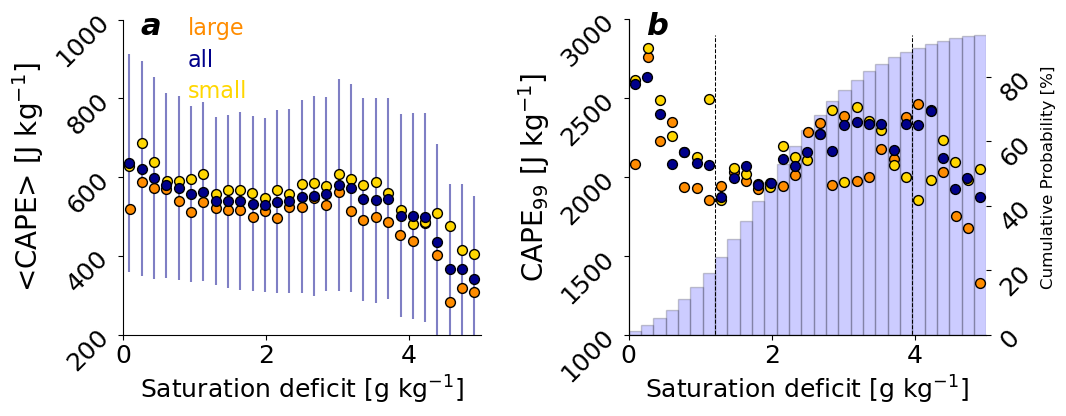

In [22]:
fig, ax = plt.subplots( 1, 2, figsize =(11, 4.5) )

ylab = [ r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]', r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]',
         r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]']
labels = [ '', '',  r'Saturation Deficit [g kg$^{-1}$]', r'Saturation Deficit [g kg$^{-1}$]' ]
let = [ 'a', 'b' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 5] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    #axis.get_xticks().set_rotation(45)
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+4, weight='bold', style='italic' )
    
    aaa=0.6
    if i == 0:
        axis.errorbar( sd_bins, cape_vals, xerr=sd_error/2, yerr=cape_error/2, color = 'darkblue', ls='none', zorder=0, 
                     alpha=0.5 )
        #axis.scatter( sd_bins_old, cape_vals_old, s=50, color='pink', edgecolor='k' )
        #axis.scatter( sd_bins_young, cape_vals_young, s=50, color='darkred', edgecolor='k' )
        axis.scatter( sd_bins_large, cape_vals_large, s=50, color='darkorange', edgecolor='k' )
        axis.scatter( sd_bins_small, cape_vals_small, s=50, color='gold', edgecolor='k' )
        #axis.scatter( sd_bins_deep, cape_vals_deep, s=50, color='turquoise', edgecolor='k' )
        #axis.scatter( sd_bins_shallow, cape_vals_shallow, s=50, color='green', edgecolor='k' )
        axis.scatter( sd_bins, cape_vals, s=50, color='darkblue', edgecolor='k', zorder=10 )
        axis.text( 0.18, 0.75, 'small', transform=axis.transAxes, color='gold', fontsize=16 )
        axis.text( 0.18, 0.85, r'all', transform=axis.transAxes, color='darkblue', fontsize=16 )
        axis.text( 0.18, 0.95, r'large', transform=axis.transAxes, color='darkorange', fontsize=16 )
        axis.set_ylim([200, 1000])
        axis.set_xlabel( r'Saturation deficit [g kg$^{-1}$]', fontsize=font_size )
    elif i == 1:
        wgts = np.ones_like( sd_ERAI )/float(len(sd_ERAI))*100.
        axis2 = axis.twinx()
        axis.set_zorder(10)
        axis.patch.set_visible(False)
        h = axis2.hist( sd_ERAI, bins=np.linspace(0, sdupper, nbin), cumulative=True, weights=wgts, alpha=0.2, edgecolor='k', color='blue' )
        print(h)
        axis2.spines['top'].set_visible( False )
        axis2.spines['right'].set_visible( False )
        axis2.set_axisbelow( True )
        axis2.set_ylabel( 'Cumulative Probability [%]', fontsize=12 )
        for t in axis2.get_yticklabels():
            t.set_rotation(45)
        
        axis.scatter( sd_bins_large, cape_99_vals_large, s=50, color='darkorange', edgecolor='k' )
        axis.scatter( sd_bins_small, cape_99_vals_small, s=50, color='gold', edgecolor='k' )
        axis.plot( [1.20689655, 1.20689655], [0, 2900], color='k', lw=0.75, ls='--' ) #24%
        axis.plot( [3.96551724, 3.96551724], [0, 2900], color='k', lw=0.75, ls='--' ) #89%
        axis.scatter( sd_bins, cape_99_vals, s=50, color='darkblue', edgecolor='k', zorder=10 )
        axis.set_ylim([1000, 3000])
        axis.set_xlabel( r'Saturation deficit [g kg$^{-1}$]', fontsize=font_size )

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/sd-cape-ERAI-percentiles.pdf', bbox_inches='tight' )
plt.show()

In [11]:
# What are the slopes of linear regressions of SDpre-CAPE, SD-CAPEpre, etc.?
i = np.argwhere( (~np.isnan(sdpre_bins)) & (~np.isnan(cape_vals2)) )
out = scipy.stats.linregress( x=sdpre_bins[i[:,0]], y=cape_vals2[i[:,0]] )
print(out)
print(out.slope)

i = np.argwhere( (~np.isnan(sd_bins)) & (~np.isnan(cape_vals)) )
out = scipy.stats.linregress( x=sd_bins[i[:,0]], y=cape_vals[i[:,0]] )
print(out)

LinregressResult(slope=-118.6177255402313, intercept=693.2737389445159, rvalue=-0.9250359289479381, pvalue=5.25950545052445e-12, stderr=9.742423140621572, intercept_stderr=26.153430461562984)
-118.6177255402313
LinregressResult(slope=-37.4433026969187, intercept=622.0353844513018, rvalue=-0.7836229837040093, pvalue=4.978423360367831e-07, stderr=5.712710226103314, intercept_stderr=16.481890374766447)


In [12]:
# What are the slopes of linear regressions of SD-CAPE99 for the range of ZBP behavior?
print(sd_bins)
sd_zbp = sd_bins[5:17]
cape99_zbp = cape_99_vals[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

sd_zbp = sd_bins_small[5:17]
cape99_zbp = cape_99_vals_small[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_large[5:17]
cape99_zbp = cape_99_vals_large[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_old[5:17]
cape99_zbp = cape_99_vals_old[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_young[5:17]
cape99_zbp = cape_99_vals_young[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_shallow[5:17]
cape99_zbp = cape_99_vals_shallow[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_deep[5:17]
cape99_zbp = cape_99_vals_deep[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

[0.08950842 0.26323159 0.43489575 0.60662888 0.77793338 0.95130236
 1.12227859 1.29595424 1.46704461 1.6388354  1.81010931 1.98303963
 2.15415443 2.32677669 2.49905612 2.67055911 2.84351647 3.01564074
 3.18868061 3.36077133 3.53288922 3.70407425 3.87948156 4.04891754
 4.22216942 4.39469603 4.56881728 4.73670065 4.90861048        nan]
LinregressResult(slope=104.46592234778987, intercept=1866.9863409378088, rvalue=0.5915051788501406, pvalue=0.04278316953651112, stderr=45.031187244418724, intercept_stderr=89.50522004518513)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4.836160398620007
138.24748510153356
198.06756712765537
27.7342180525851
124.31330927182131
154.2000564081184


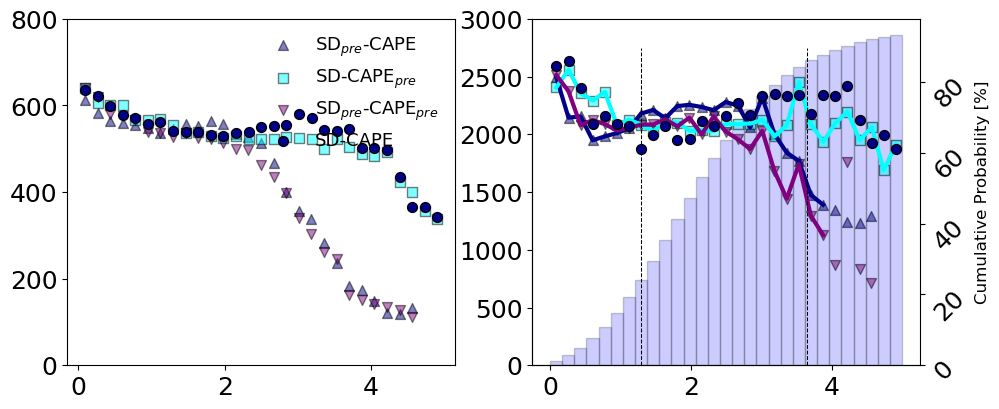

In [23]:
fig, ax = plt.subplots( 1, 2, figsize =(11, 4.5) )

ylab = [ r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]', r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]',
         r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]']
labels = [ '', '',  r'Saturation Deficit [g kg$^{-1}$]', r'Saturation Deficit [g kg$^{-1}$]' ]
let = [ 'a', 'b' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
aaa=0.5

for i, axis in enumerate(ax.flat): 
    if i == 0:
        axis.scatter( sdpre_bins, cape_vals2, s=50, marker='^', color='darkblue', alpha=aaa, edgecolor='k',
                        label=r'SD$_{pre}$-CAPE')
        axis.scatter( sd_bins, capepre_vals, s=50, marker='s', color='cyan', alpha=aaa, edgecolor='k',
                        label=r'SD-CAPE$_{pre}$')
        axis.scatter( sdpre_bins2, capepre_vals2, s=50, marker='v', color='purple', alpha=aaa, edgecolor='k',
                        label=r'SD$_{pre}$-CAPE$_{pre}$')
        axis.scatter( sd_bins, cape_vals, s=50, color='darkblue', edgecolor='k', label='SD-CAPE' )
        axis.legend( frameon=False, fontsize=13, loc='upper right' )
        axis.set_ylim([0, 800])
    elif i == 1:
        wgts = np.ones_like( sd_ERAI )/float(len(sd_ERAI))*100.
        axis2 = axis.twinx()
        axis.set_zorder(10)
        axis.patch.set_visible(False)
        axis2.hist( sd_ERAI, bins=np.linspace(0, sdupper, nbin), cumulative=True, weights=wgts, alpha=0.2, edgecolor='k', color='blue' )
        axis2.spines['top'].set_visible( False )
        axis2.spines['right'].set_visible( False )
        axis2.set_axisbelow( True )
        axis2.set_ylabel( 'Cumulative Probability [%]', fontsize=12 )
        for t in axis2.get_yticklabels():
            t.set_rotation(45)
        
        axis.scatter( sdpre_bins, cape_99_vals2, s=50, marker='^', color='darkblue', alpha=aaa, edgecolor='k' )
        axis.plot( sdpre_bins[0:-7], cape_99_vals2[0:-7], color='darkblue', lw=3 )
        axis.scatter( sd_bins, capepre_99_vals, s=50, marker='s', color='cyan', alpha=aaa, edgecolor='k' )
        axis.plot( sd_bins, capepre_99_vals, color='cyan', lw=3 )
        axis.scatter( sdpre_bins2, capepre_99_vals2, s=50, marker='v', color='purple', alpha=aaa, edgecolor='k' )
        axis.plot( sdpre_bins2[:-7], capepre_99_vals2[:-7], color='purple', lw=3 )
        axis.plot( [1.2977, 1.2977], [0, 2750], color='k', lw=0.75, ls='--' )
        axis.plot( [3.645, 3.645], [0, 2750], color='k', lw=0.75, ls='--' )
        axis.scatter( sd_bins, cape_99_vals, s=50, color='darkblue', edgecolor='k', zorder=10 )
        axis.set_ylim([0, 3000])